In [1]:
from irbstudio.data.loader import FreddieMacLoader

loader = FreddieMacLoader('../data/FM/sample_svcg_*.txt', '../data/FM/sample_orig_*.txt')
df = loader.load_performance()

# Create default flag based on delinquency status
df['dpd_group'] = df['Current_Loan_Delinquency_Status'].apply(lambda x: int(x) if str(x).isdigit() else 0)
df['default_flag'] = (df['dpd_group'] >= 3)*1

# Create reporting date from YYYYMM format
import pandas as pd
df['reporting_date'] = pd.to_datetime(df['Monthly_Reporting_Period'], format='%Y%m') + pd.offsets.MonthEnd(0)

In [2]:
# Create into_default_flag: 1 if facility goes into default within next 12 months, else 0
df = df.sort_values(['Loan_Sequence_Number', 'reporting_date'])
df['into_default_flag'] = (
    df.groupby('Loan_Sequence_Number')['default_flag']
    .transform(lambda x: x.rolling(window=12, min_periods=1).max().shift(-1).fillna(0))
    .astype(int)
)

In [3]:
import numpy as np
# Adjust into_default_flag for facilities with less than 12 months of history
facility_counts = df.groupby('Loan_Sequence_Number')['reporting_date'].count()
short_facilities = facility_counts[facility_counts < 12].index

mask_short = df['Loan_Sequence_Number'].isin(short_facilities)
mask_no_default = (df['into_default_flag'] == 0) & (df['default_flag'] == 0)

df.loc[mask_short & mask_no_default, 'into_default_flag'] = np.nan

In [4]:
# Find the most recent 12 months in the portfolio
latest_months = df['reporting_date'].sort_values(ascending=False).unique()[:12]

# Filter: keep rows where into_default_flag is not NaN,
# or where reporting_date is in the most recent 12 months
df_filtered = df[(~df['into_default_flag'].isna()) | (df['reporting_date'].isin(latest_months))]

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Select a sample for quick fitting (e.g., 50,000 rows, stratified by into_default_flag)
sample_df = df_filtered.dropna(subset=['into_default_flag'])
sample_df = sample_df.sample(frac=1, random_state=42)  # Shuffle
sample_df, _ = train_test_split(
    sample_df, 
    train_size=2500, 
    stratify=sample_df['into_default_flag'], 
    random_state=42
)

# Simple feature selection (you can adjust as needed)
features = ['Loan_Age', 'Estimated_Loan-to-Value_(ELTV)', 'Current_Interest_Rate', 'dpd_group']
X = sample_df[features]
y = sample_df['into_default_flag']

# Fit logistic regression
model = LogisticRegression(max_iter=100, solver='lbfgs')
model.fit(X, y)

# Score the whole df_filtered (fillna for missing features)
X_full = df_filtered[features].fillna(0)
df_filtered['score'] = model.predict_proba(X_full)[:, 1]

C:\Users\jacek\AppData\Local\Temp\ipykernel_3644\2673849412.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['score'] = model.predict_proba(X_full)[:, 1]


In [6]:
from sklearn.metrics import roc_auc_score, roc_curve
df_check = df_filtered.dropna(subset=['into_default_flag'])
roc_auc_score(df_check['into_default_flag'], df_check['score'])

0.8322392859210059

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import check_random_state
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

def stable_binning(df, score_col, target_col, date_col, min_grades=9, min_bin_size=100, random_state=42):
    """
    Bins scores into rating grades with constraints:
    - At least min_grades bins
    - Homogeneous default rates within bins
    - Heterogeneous default rates between bins
    - Over-time stability (default rates within bins don't cross over time)
    Returns: DataFrame with new 'rating' column and bin edges
    """
    # Prepare data for binning
    scores = df[score_col].values.reshape(-1, 1)
    y = df[target_col].values

    # Use DecisionTree to find bins with different default rates
    tree = DecisionTreeClassifier(
        max_leaf_nodes=min_grades,
        min_samples_leaf=min_bin_size,
        random_state=random_state
    )
    # Use into_default_flag as target (future default)
    tree.fit(scores, df['into_default_flag'])

    # Get bin edges
    thresholds = sorted(tree.tree_.threshold[tree.tree_.threshold > -2])
    bin_edges = [-np.inf] + thresholds + [np.inf]

    # Assign ratings
    df['rating_bin'] = pd.cut(df[score_col], bins=bin_edges, labels=[str(i+1) for i in range(len(bin_edges)-1)], include_lowest=True)

    # Homogeneity: check default rates within bins
    bin_stats = df.groupby('rating_bin')[target_col].agg(['mean', 'count'])
    print("Default rates by rating bin:\n", bin_stats)

    # Heterogeneity: test statistical difference between bins
    contingency = pd.crosstab(df['rating_bin'], df[target_col])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f"\nChi2 test p-value (heterogeneity): {p:.4g}")

    # Over-time stability: check default rates by bin over time
    stability = df.groupby([date_col, 'rating_bin'])[target_col].mean().unstack()
    stability.plot(title="Default Rate by Rating Bin Over Time", figsize=(12,6))
    plt.ylabel("Default Rate")
    plt.show()

    return df, bin_edges

In [8]:
sample_df = df_filtered.dropna(subset=['into_default_flag'])
sample_df = sample_df.sample(frac=1, random_state=42)  # Shuffle


C:\Users\jacek\AppData\Local\Temp\ipykernel_3644\3263210592.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby('rating_bin')[target_col].agg(['mean', 'count'])


Default rates by rating bin:
                 mean    count
rating_bin                   
1           0.002535  3735019
2           0.009101  2528755
3           0.002714  2048251
4           0.046952    23620
5           0.076817    39197
6           0.567150    16061
7           0.972786    49165

Chi2 test p-value (heterogeneity): 0


C:\Users\jacek\AppData\Local\Temp\ipykernel_3644\3263210592.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stability = df.groupby([date_col, 'rating_bin'])[target_col].mean().unstack()


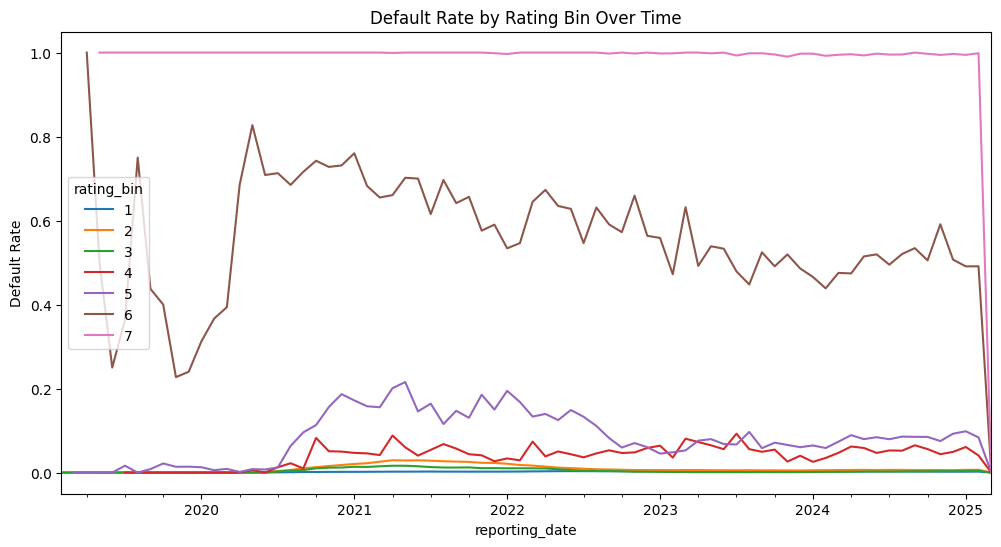

In [9]:
sample_df, bin_edges = stable_binning(
    sample_df,
    score_col='score',
    target_col='into_default_flag',
    date_col='reporting_date',
    min_grades=7,
    min_bin_size=10000,
    random_state=42
)

C:\Users\jacek\AppData\Local\Temp\ipykernel_3644\214002595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['rating'] = df_filtered['rating'].cat.add_categories(['20'])


In [15]:
df_filtered['rating'] = pd.cut(df_filtered['score'], bins=bin_edges, labels=[str(i+1) for i in range(len(bin_edges)-1)], include_lowest=True)
df_filtered['rating'] = df_filtered['rating'].cat.add_categories(['20'])
df_filtered.loc[df_filtered['default_flag'] == 1, 'rating'] = '20'

C:\Users\jacek\AppData\Local\Temp\ipykernel_3644\4102062422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['rating'] = pd.cut(df_filtered['score'], bins=bin_edges, labels=[str(i+1) for i in range(len(bin_edges)-1)], include_lowest=True)
C:\Users\jacek\AppData\Local\Temp\ipykernel_3644\4102062422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['rating'] = df_filtered['rating'].cat.add_categories(['20'])


In [16]:
df_filtered.to_csv('../data/sample_portfolio_data_fm.csv', index=False)